In [25]:
!pip install fbprophet

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score,mean_absolute_error
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
# Hyperparameter tuning
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import itertools
def best_para(df,date1,date2):
    param_grid = {  
        'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
        'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0]
    }
    print(type(date1))
    cutoffs = pd.to_datetime([date1,date2])

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(df)  # Fit model with given params
        df_cv = cross_validation(m,cutoffs=cutoffs,horizon = '365 days' ,parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    best_params = all_params[np.argmin(rmses)]
    return [best_params.get('changepoint_prior_scale'), best_params.get('seasonality_prior_scale')]

In [ ]:
a = best_para(df_6N,'2018-08-01','2019-08-01')

In [ ]:
best_params = all_params[np.argmin(rmses)]
temp = [best_params.get('changepoint_prior_scale'),best_params.get('seasonality_prior_scale')]
print(temp,temp[0])

[1, 0.001]


In [68]:
from pandas import to_datetime
from pandas import DataFrame
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from glob import glob

md_dict,xt_dict,yt_dict,zt_dict = {}, {}, {}, {}
dict_1 = {'group':[],'well_name':[],
        # 'Prophet_train_r2':[],'Prophet_train_mae':[],'Prophet_train_rmse':[],
        'Prophet_test_r2':[],'Prophet_test_mae':[],'Prophet_test_rmse':[]}
df_result = pd.DataFrame(dict_1)

path = "/content/drive/My Drive/Python/OilProduction/Revision/data/"
filenames = glob(path+'prod_df/Wilson/'+'*.csv')
for filename in filenames[7:8]: 
    df = pd.read_csv(filename,usecols=['Date','oil/day'])
    well = str(filename[-17:-4])
    # print (well)
    #filename: '/content/drive/My Drive/Python/OilProduction/Revision/data/prod_df/Gobbler/5123359990000.csv'
    df=df.rename(columns={"Date": "ds", 
                          "oil/day": "y"})
    df['ds']= to_datetime(df['ds'])
    # print(df[:train_size])
    train_size = int(len(df['ds']) * 0.7)
    # print (train_size)
    # print(len(df['ds'])-train_size)
    # print(df['ds'][train_size]) #2021-04-01
    # print(df['ds'][train_size].strftime('%Y-%m-%d'))
    # print(pd.to_datetime(df['ds'][train_size])-relativedelta(months=+12))
    # date1 = df['ds'][(train_size-1)].strftime('%Y-%m-%d')
    # date2 = str((pd.to_datetime(df['ds'][(train_size-1)])-relativedelta(months=+12)).strftime('%Y-%m-%d'))
    # print(date1)
    # print(date2)
    # temp = best_para(df[:train_size],'2020-03-01','2021-03-01')
    model = Prophet(changepoint_prior_scale = 1,#temp[0]
                seasonality_prior_scale = 0.001#temp[1]
                # seasonality_prior_scale = 0.002
                )  #By default, "changepoint_prior_scale" is set to 0.05. Increasing it will make the trend more flexible
    model.fit(df[:train_size])

    future=df['ds'][train_size:]
    future = DataFrame(future).reset_index(drop=True)
    future.columns = ['ds']
    future['ds']= to_datetime(future['ds'])
    
    forecast = model.predict(future)
    
    y_true = df['y'][train_size:].values
    y_pred = forecast['yhat'].values
    dict_2 = {'group':'CritterCreek',
           'well_name': well, 
          #  'Prophet_train_r2':'%.2f'% r2_score(trainY[0], trainPredict[:,0]),
          #  'Prophet_train_mae':'%.2f'% mean_absolute_error(trainY[0], trainPredict[:,0]),
          #  'Prophet_train_rmse':'%.2f'% math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])),
           'Prophet_test_r2': '%.2f'% r2_score(y_true, y_pred),
           'Prophet_test_mae': '%.2f'% mean_absolute_error(y_true, y_pred),
           'Prophet_test_rmse':'%.2f'% np.sqrt(mean_squared_error(y_true, y_pred))}
    df_result = df_result.append(dict_2, ignore_index = True)
    # df_result.to_csv(path+'/export/CritterCreek_13wells_Prophet_new.csv',index=False)
print(df_result)

21


# CC-5123454330000

In [62]:
df_CC=pd.read_csv('/content/drive/MyDrive/Python/OilProduction/Revision/data/prod_df/Wilson/5123454330000.csv',
               usecols=['Date','oil/day'])
df_CC=df_CC.rename(columns={"Date": "ds", 
                      "oil/day": "y"})
df_CC['ds']= to_datetime(df_CC['ds'])
print(df_CC)

           ds       y
0  2019-08-01  246.89
1  2019-09-01  503.47
2  2019-10-01  481.82
3  2019-11-01  455.82
4  2019-12-01  369.90
5  2020-01-01  157.38
6  2020-02-01  336.46
7  2020-03-01  282.35
8  2020-04-01  248.17
9  2020-05-01  216.45
10 2020-06-01  189.80
11 2020-07-01  175.45
12 2020-08-01  160.23
13 2020-09-01  150.40
14 2020-10-01  139.58
15 2020-11-01  126.50
16 2020-12-01   34.11
17 2021-01-01   76.06
18 2021-02-01   64.21
19 2021-03-01   63.80
20 2021-04-01   67.07
21 2021-05-01   68.71
22 2021-06-01   70.87
23 2021-07-01   69.03
24 2021-08-01   64.48
25 2021-09-01   61.90
26 2021-10-01   60.26
27 2021-11-01   60.00
28 2021-12-01   62.00


In [63]:
# Hyperparameter tuning
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import itertools

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0]
}

cutoffs = pd.to_datetime(['2019-11-01','2020-11-01'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_CC)  # Fit model with given params
    df_cv = cross_validation(m,cutoffs=cutoffs,horizon = '180 days' ,parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

best_params = all_params[np.argmin(rmses)]
print(best_params)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe21fadc290>
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe21f8f62d0>
INFO:fbprophet:n_changepoints greater than number o

{'changepoint_prior_scale': 1, 'seasonality_prior_scale': 0.001}


#6N

In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import sklearn
import matplotlib.pyplot as plt

from pandas import to_datetime
from pandas import DataFrame

In [61]:
df_6N=pd.read_csv('/content/drive/MyDrive/Python/OilProduction/6N/6N_Prod.csv',
               usecols=['FirstOfMonth','OilProduced(bbl/day)'],
               )
# df['y'] = np.log(df['y'])
df_6N=df_6N.rename(columns={"FirstOfMonth": "ds", 
                      "OilProduced(bbl/day)": "y"})
df_6N['ds']= to_datetime(df_6N['ds'])
# model = Prophet(changepoint_prior_scale = 0.2,
#                 # growth='logistic',
#                 weekly_seasonality=False,
#                 daily_seasonality=False
#                 )  #By default, "changepoint_prior_scale" is set to 0.05. Increasing it will make the trend more flexible
# model.fit(df)
print(df_6N)

           ds    y
0  2013-09-01  347
1  2013-10-01  453
2  2013-11-01  332
3  2013-12-01  261
4  2014-01-01  215
..        ...  ...
80 2020-05-01    9
81 2020-06-01    9
82 2020-07-01    9
83 2020-08-01    9
84 2020-09-01    8

[85 rows x 2 columns]


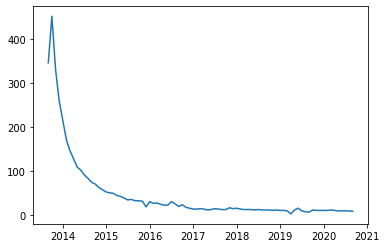

In [57]:
plt.plot(df_6N['ds'],df_6N['y'])

In [60]:
# Hyperparameter tuning
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import itertools

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0]
}

cutoffs = pd.to_datetime(['2018-08-01','2019-08-01'])
# cutoffs = pd.to_datetime(['2017-08-01','2018-08-01'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_6N)  # Fit model with given params
    df_cv = cross_validation(m,cutoffs=cutoffs,
                             horizon ='365 days',
                             parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SystemError: ignored

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 1, 'seasonality_prior_scale': 0.001}


## Model1 - Season=0.001

In [ ]:
model = Prophet(changepoint_prior_scale = 1,
                seasonality_prior_scale = 0.001
                # seasonality_prior_scale = 0.002
                )  #By default, "changepoint_prior_scale" is set to 0.05. Increasing it will make the trend more flexible
model.fit(df[:60])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future=df['ds'][60:]
future = DataFrame(future).reset_index(drop=True)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

          ds       yhat  yhat_lower  yhat_upper
0 2018-09-01  10.763869   -6.024059   28.545807
1 2018-10-01  12.555785   -5.382684   29.940593
2 2018-11-01  11.327716   -8.973295   32.068348
3 2018-12-01  10.802179  -10.743633   33.666212
4 2019-01-01  10.943320  -15.311973   37.672617


Text(0.5, 1.0, 'Oil Production (Traing & Predicted Datasets)')

<Figure size 576x432 with 0 Axes>

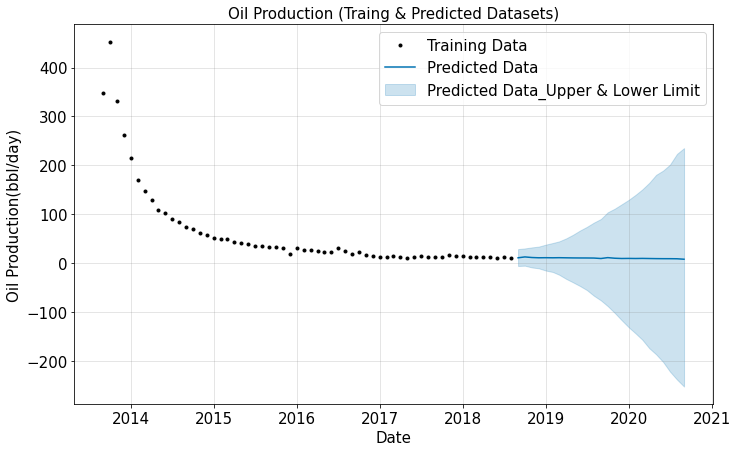

In [ ]:
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
# forecast.head()
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
plt.figure(figsize=(8,6))
model.plot(forecast)
plt.ylabel('Oil Production(bbl/day)',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.legend(['Training Data', 'Predicted Data','Predicted Data_Upper & Lower Limit'],loc='upper right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production (Traing & Predicted Datasets)',fontsize=15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



(0.0, 20.0)

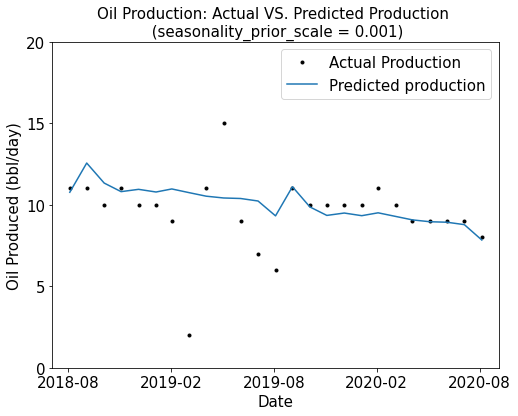

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = forecast['ds']
y1 = forecast['yhat']
# y2 = forecast['yhat_lower']
# y3 = forecast['yhat_upper']
y4 = df['y'][60:]
plt.figure(figsize=(8,6))
plt.plot(x1,y4,'.',color='black', label='Actual Production')
plt.plot(x1,y1,label='Predicted production')
# plt.plot(x1,y2)
# plt.plot(x1,y3)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/day)',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production: Actual VS. Predicted Production \n (seasonality_prior_scale = 0.001)',fontsize=15)
# plt.show()

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
ax = plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #'%Y-%m-%d %H:%M:%S'
ax.xaxis.set_major_locator(ticker.MultipleLocator(182.5))
ax.set_xlim(pd.Timestamp('2018-08'),pd.Timestamp('2020-10'))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_ylim(0,20)

Evaluate the model

In [ ]:
# calculate MAE between expected and predicted values for december
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error

y_true = df['y'][60:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
r2=r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('MAE: %.2f' % mae)
print('R2 score: %.2f' % r2)
print('rmse: %.2f' % rmse)

MAE: 1.34
R2 score: -0.08
rmse: 2.32


## Model2 - Season = 0.002

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



(0.0, 20.0)

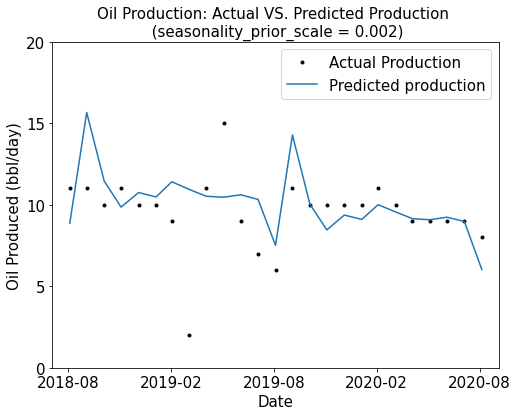

In [ ]:
model2 = Prophet(changepoint_prior_scale = 1,
                seasonality_prior_scale = 0.002
                )  #By default, "changepoint_prior_scale" is set to 0.05. Increasing it will make the trend more flexible
model2.fit(df[:60])

future2=df['ds'][60:]
future2 = DataFrame(future2).reset_index(drop=True)
future2.columns = ['ds']
future2['ds']= to_datetime(future2['ds'])

# use the model to make a forecast
forecast2 = model2.predict(future2)

# plot forecast
# plt.figure(figsize=(8,6))
model2.plot(forecast2)
# plt.ylabel('Oil Production(bbl/day)',fontsize=15)
# plt.xlabel('Date',fontsize=15)
# plt.legend(['Training Data', 'Predicted Data','Predicted Data_Upper & Lower Limit'],loc='upper right',fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.title('Oil Production (Traing & Predicted Datasets)',fontsize=15)

import matplotlib.pyplot as plt
%matplotlib inline

x2 = forecast2['ds']
y2 = forecast2['yhat']
y4 = df['y'][60:]
plt.figure(figsize=(8,6))
plt.plot(x2,y4,'.',color='black', label='Actual Production')
plt.plot(x2,y2,label='Predicted production')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/day)',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production: Actual VS. Predicted Production \n (seasonality_prior_scale = 0.002)',fontsize=15)
# plt.show()

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
ax = plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #'%Y-%m-%d %H:%M:%S'
ax.xaxis.set_major_locator(ticker.MultipleLocator(182.5))
ax.set_xlim(pd.Timestamp('2018-08'),pd.Timestamp('2020-10'))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_ylim(0,20)

In [ ]:
y2.values

array([ 8.86727881, 15.6548189 , 11.45340882,  9.85342318, 10.74718372,
       10.47536462, 11.40832629, 10.93446978, 10.5196924 , 10.46002795,
       10.60866146, 10.3265957 ,  7.50951383, 14.27796864, 10.031635  ,
        8.45597373,  9.36594763,  9.09837239, 10.00182188,  9.55699661,
        9.14588427,  9.07847867,  9.23339627,  8.97076306,  6.03103569])

In [ ]:
# calculate MAE between expected and predicted values for december
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error

y_true = df['y'][60:].values
# y_pred2 = forecast2['yhat'].values
y_pred2 = y2.values
mae_2 = mean_absolute_error(y_true, y_pred2)
r2_2=r2_score(y_true, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y_true, y_pred2))
print('MAE_2: %.2f' % mae_2)
print('R2 score_2: %.2f' % r2_2)
print('rmse_2: %.2f' % rmse_2)

MAE_2: 1.75
R2 score_2: -0.39
rmse_2: 2.63


1、均方误差：MSE（Mean Squared Error）
2、均方根误差：RMSE（Root Mean Squard Error）RMSE=sqrt（MSE）。
3、平均绝对误差：MAE（Mean Absolute Error）
4、决定系数：R2（R-Square）
一般来说，R-Squared 越大，表示模型拟合效果越好。R-Squared 反映的是大概有多准，因为，随着样本数量的增加，R-Square必然增加，无法真正定量说明准确程度，只能大概定量。

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

mse = mean_squared_error(testY,testPredict)
rmse = np.sqrt(mean_squared_error(testY,testPredict))
mae = mean_absolute_error(testY,testPredict)
r2 = r2_score(testY,testPredict)

In [ ]:
# forecast

Text(45.75, 0.5, 'Yearly Trend')

<Figure size 720x504 with 0 Axes>

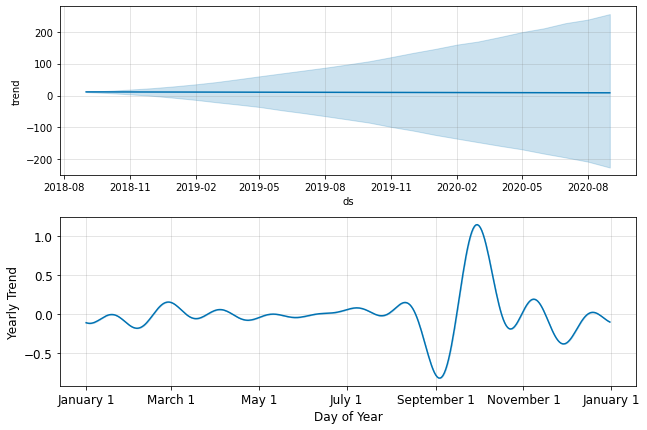

In [ ]:
# fig=model.plot_components(forecast)

plt.figure(figsize=(10,7))
model.plot_components(forecast)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Day of Year',fontsize=12)
plt.ylabel('Yearly Trend',fontsize=12)


# plt.figure(figsize=(12,8))
# x1 = forecast['ds']
# y1 = forecast['yearly']
# plt.plot(x1,y1,label='Yearly Trend')

# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.title('Trend of Yearly Production',fontsize=15)

What you'll want to do instead is manually specify the cutoff locations. Suppose I have monthly data from 2018-01-01 through 2020-09-01 and I want to do cross validation with a forecast horizon of 3 months, starting with 1 year of training data and then moving forward with a period of 2 months. I could manually create the appropriate set of cutoffs like:


In [65]:
import pandas as pd
cutoffs = pd.date_range(start='2019-01-01', end='2020-06-01', freq='2MS')
print(cutoffs)

DatetimeIndex(['2019-01-01', '2019-03-01', '2019-05-01', '2019-07-01',
               '2019-09-01', '2019-11-01', '2020-01-01', '2020-03-01',
               '2020-05-01'],
              dtype='datetime64[ns]', freq='2MS')


And then specify those as the cutoffs to use:

In [ ]:
df_cv = cross_validation(model=model, horizon='90 days', cutoffs=cutoffs)